In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\train.csv") 
test_df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\test.csv")

c:\Users\ignac\Python\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ignac\Python\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


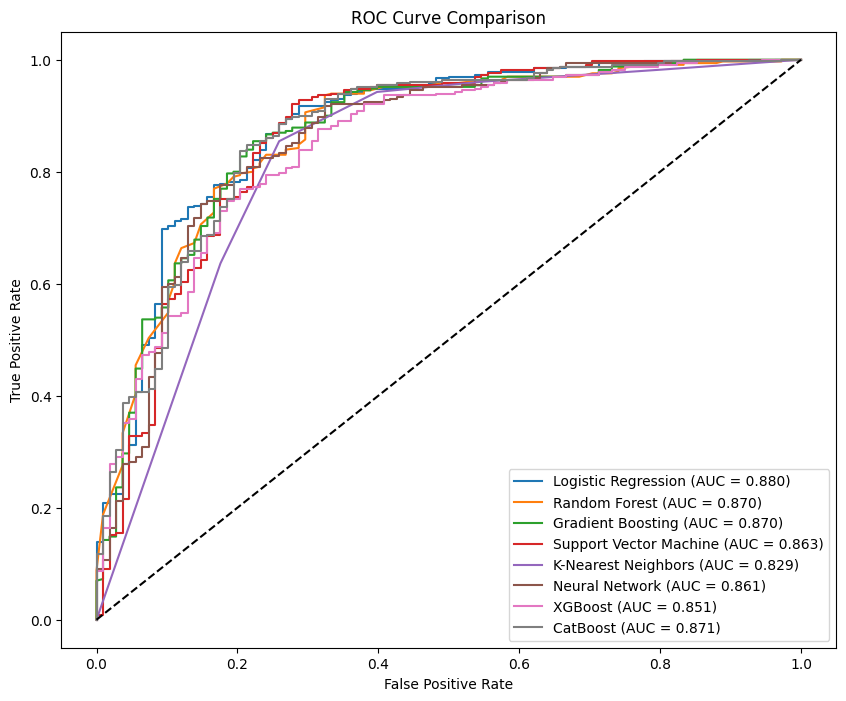

In [7]:
# Ensure correct column names
test_df.columns = test_df.columns.str.strip()

X_test = test_df

X = df.drop(columns=['rainfall', 'id'])  # Drop 'id' column from training data
y = df['rainfall']

# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize data for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Train models and evaluate performance
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name in ["Logistic Regression", "Support Vector Machine", "Neural Network", "K-Nearest Neighbors"]:
        model.fit(X_train_scaled, y_train)
        y_probs = model.predict_proba(X_val_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_val)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot ROC Curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

[I 2025-03-06 00:46:30,004] A new study created in memory with name: no-name-4996c21a-3fbb-4b1f-ad87-63b58284898d
C:\Users\ignac\AppData\Local\Temp\ipykernel_8048\310396244.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-03-06 00:46:30,030] Trial 0 finished with value: 0.8930126242375641 and parameters: {'C': 0.003533637794218292, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.8930126242375641.
C:\Users\ignac\AppData\Local\Temp\ipykernel_8048\310396244.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-03-06 00:46:30,049] Trial 1 finished with value: 0.895

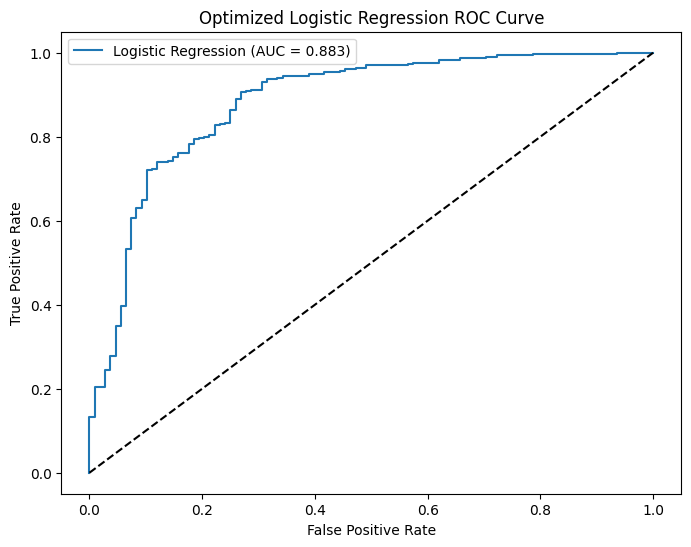

Best Hyperparameters: {'C': 0.03176249095827928, 'solver': 'liblinear'}


In [10]:
import optuna

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    
    model = LogisticRegression(C=C, solver=solver, max_iter=1000)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return np.mean(scores)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train final model with best hyperparameters
best_params = study.best_params
final_model = LogisticRegression(**best_params, max_iter=1000)
final_model.fit(X_train_scaled, y_train)

y_probs = final_model.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Optimized Logistic Regression ROC Curve")
plt.legend()
plt.show()

print("Best Hyperparameters:", best_params)


In [34]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    solver = 'saga'  # Required for ElasticNet penalty
    
    model = LogisticRegression(C=C, solver=solver, penalty='elasticnet', l1_ratio=l1_ratio, max_iter=1000)
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
    return np.mean(scores)

# Load dataset
df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\train.csv")
test_df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\test.csv", index_col=None)

test_df.columns = test_df.columns.str.strip()
if 'id' in test_df.columns:
    test_ids = test_df['id']
    X_test = test_df.drop(columns=['id'])
else:
    raise KeyError("'id' column not found in test dataset")

X = df.drop(columns=['rainfall', 'id'])  # Drop 'id' column from training data
y = df['rainfall']

# Feature Engineering
X['temp_range'] = X['maxtemp'] - X['mintemp']
X['humidity_ratio'] = X['humidity'] / (X['dewpoint'] + 1)
X['wind_power'] = X['windspeed'] ** 2

X_test['temp_range'] = X_test['maxtemp'] - X_test['mintemp']
X_test['humidity_ratio'] = X_test['humidity'] / (X_test['dewpoint'] + 1)
X_test['wind_power'] = X_test['windspeed'] ** 2

# Binning wind speed into categories
bins = [0, 5, 15, np.inf]  # Define bin edges
labels = ['low', 'medium', 'high']  # Define labels
X['wind_category'] = pd.cut(X['windspeed'], bins=bins, labels=labels)
X_test['wind_category'] = pd.cut(X_test['windspeed'], bins=bins, labels=labels)

# One-hot encode the categorical feature
X = pd.get_dummies(X, columns=['wind_category'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['wind_category'], drop_first=True)

# Ensure X_test has the same columns as X
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Generate Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_imputed)
X_test_poly = poly.transform(X_test_imputed)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Define base models
logistic_model = LogisticRegression(C=0.03176, solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=1000)
neural_net = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000)

# Stacking Classifier with 30% contribution from Neural Network
stacking_model = StackingClassifier(
    estimators=[('lr', logistic_model), ('mlp', neural_net)],
    final_estimator=LogisticRegression(),
    passthrough=True
)

stacking_model.fit(X_scaled, y)

# Feature Selection based on Logistic Regression coefficients
feature_importance = np.abs(stacking_model.final_estimator_.coef_).flatten()
feature_names = poly.get_feature_names_out(input_features=X.columns)
important_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Print Top 10 Important Features
print("Top 10 Important Features:")
for feature, importance in important_features[:10]:
    print(f"{feature}: {importance:.5f}")

# Generate predictions
test_preds = stacking_model.predict_proba(X_test_scaled)[:, 1]
submission = pd.DataFrame({"id": test_ids, "rainfall": test_preds})
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")


Top 10 Important Features:
humidity winddirection: 1.34972
winddirection: 1.32452
pressure winddirection: 1.28841
humidity_ratio wind_power: 1.15574
day temp_range: 1.02610
sunshine windspeed: 0.90371
humidity_ratio wind_category_medium: 0.85749
temparature: 0.83574
sunshine temp_range: 0.82284
day cloud: 0.77929
Submission file saved as submission.csv


c:\Users\ignac\Python\env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import shap
import optuna
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, ClassifierMixin

# Load dataset
df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\train.csv")
test_df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\test.csv", index_col=None)

# Define top 10 important features
important_features = [
    "dewpoint", "humidity", "pressure", "sunshine", "cloud", 
    "mintemp", "maxtemp"
]

# Prepare training data
X = df[important_features]
y = df['rainfall']
X_test = test_df[important_features]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
X_test = imputer.transform(X_test)

# Generate Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Split training data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

test_df.columns = test_df.columns.str.strip()
if 'id' in test_df.columns:
    test_ids = test_df['id']
    X_test = test_df.drop(columns=['id'])
else:
    raise KeyError("'id' column not found in test dataset")

X = df.drop(columns=['rainfall', 'id'])  # Drop 'id' column from training data
y = df['rainfall']

# Feature Engineering
X['temp_range'] = X['maxtemp'] - X['mintemp']
X['humidity_ratio'] = X['humidity'] / (X['dewpoint'] + 1)
X['wind_power'] = X['windspeed'] ** 2
X['pressure_humidity'] = X['pressure'] * X['humidity']
X['cloud_sunshine'] = X['cloud'] * X['sunshine']
X['pressure_sq'] = X['pressure'] ** 2
X['humidity_sq'] = X['humidity'] ** 2
X['pressure_cubic'] = X['pressure'] ** 3
X['humidity_cubic'] = X['humidity'] ** 3

X_test['temp_range'] = X_test['maxtemp'] - X_test['mintemp']
X_test['humidity_ratio'] = X_test['humidity'] / (X_test['dewpoint'] + 1)
X_test['wind_power'] = X_test['windspeed'] ** 2
X_test['pressure_humidity'] = X_test['pressure'] * X_test['humidity']
X_test['cloud_sunshine'] = X_test['cloud'] * X_test['sunshine']
X_test['pressure_sq'] = X_test['pressure'] ** 2
X_test['humidity_sq'] = X_test['humidity'] ** 2
X_test['pressure_cubic'] = X_test['pressure'] ** 3
X_test['humidity_cubic'] = X_test['humidity'] ** 3

# Binning wind speed into categories
bins = [0, 5, 15, np.inf]  # Define bin edges
labels = ['low', 'medium', 'high']  # Define labels
X['wind_category'] = pd.cut(X['windspeed'], bins=bins, labels=labels)
X_test['wind_category'] = pd.cut(X_test['windspeed'], bins=bins, labels=labels)

# One-hot encode the categorical feature
X = pd.get_dummies(X, columns=['wind_category'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['wind_category'], drop_first=True)

# Ensure X_test has the same columns as X
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Generate Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_imputed)
X_test_poly = poly.transform(X_test_imputed)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Feature Selection using RFE
base_logistic = LogisticRegression(C=0.03176, solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=1000)
rfe = RFE(base_logistic, n_features_to_select=30)
X_selected = rfe.fit_transform(X_scaled, y)
X_test_selected = rfe.transform(X_test_scaled)
# Define a wrapper for the Keras model
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32, **kwargs):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.kwargs = kwargs
        self.model = None

    def fit(self, X, y, **fit_params):
        self.model = self.build_fn(**self.kwargs)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, **fit_params)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return {"build_fn": self.build_fn, "epochs": self.epochs, "batch_size": self.batch_size, **self.kwargs}

    def set_params(self, **params):
        self.epochs = params.pop("epochs", self.epochs)
        self.batch_size = params.pop("batch_size", self.batch_size)
        self.build_fn = params.pop("build_fn", self.build_fn)
        self.kwargs.update(params)
        return self

def build_neural_net():
    model = Sequential([
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])
    return model

neural_net = KerasClassifierWrapper(build_fn=build_neural_net, epochs=50, batch_size=32)
neural_net.fit(X_selected, y)

# Define base models
xgb = XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=5, colsample_bytree=0.8)
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=5, colsample_bytree=0.8)

# Stacking Classifier with Logistic Regression as meta-model
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[('lr', base_logistic), ('mlp', neural_net), ('xgb', xgb), ('lgbm', lgbm)],
    final_estimator=meta_model,
    passthrough=True
)

stacking_model.fit(X_selected, y)

# Hyperparameter tuning for Logistic Regression
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e2)
    model = LogisticRegression(C=C, solver='liblinear', penalty='l1')
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_C = study.best_params['C']

# Train Logistic Regression
log_reg = LogisticRegression(C=best_C, solver='liblinear', penalty='l1')

# Train Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('mlp', mlp)],
    final_estimator=LogisticRegression()
)

# Fit the stacking model
stacking_model.fit(X_selected, y)

# Generate predictions
test_preds = stacking_model.predict_proba(X_test_selected)[:, 1]
submission = pd.DataFrame({"id": test_ids, "rainfall": test_preds})
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7865 - loss: 0.4474
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8832 - loss: 0.3478
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8985 - loss: 0.3328
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8568 - loss: 0.3881
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8753 - loss: 0.3696
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8739 - loss: 0.3657
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8986 - loss: 0.3275
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8825 - loss: 0.3471
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8747 - loss: 0.3684
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8914 - loss: 0.3465
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8794 - loss: 0.3517
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8901 - loss: 0.3420
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

c:\Users\ignac\Python\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\ignac\Python\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\ignac\Python\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\ignac\Python\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\ignac\Python\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-06 22:26:18,945] A new study created in memory with name: no-name-6013647e-8a31-4ac2-8341-8351e177af76
C:\Users\ignac\AppData\Local\Temp\ipykernel_3704\3000671659.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
[I 2025-03-06 22:26:18,952] Trial 0 finished with value: 0.728310502283105 and parameters: {'C': 0.0024297554945670726}. Best is trial 0 with value: 0.728310502283105.
C:\Users\i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-06 22:26:19,281] Trial 1 finished with value: 0.8538812785388128 and parameters: {'C': 60.85570844887207}. Best is trial 1 with value: 0.8538812785388128.
C:\Users\ignac\AppData\Local\Temp\ipykernel_3704\3000671659.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
[I 2025-03-06 22:26:19,285] Trial 2 finished with value: 0.728310502283105 and parameters: {'C': 0.0070817749269890635}. Best is trial 1 with value: 0.8538812785388128.
C:\Users\ignac\AppData\Local\Temp\ipykernel_3704\3000671659.py:181: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
[I 2025-03-06 22:26:19,29

Submission file saved as submission.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import optuna

# Load dataset
df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\train.csv")
test_df = pd.read_csv(r"C:\Users\ignac\Downloads\playground-series-s5e3\test.csv")

# Define top 10 important features
important_features = [
    "dewpoint", "humidity", "pressure", "sunshine", "cloud", 
    "mintemp", "maxtemp", "temperature"
]

# Prepare training data
X = df[important_features]
y = df['rainfall']
X_test = test_df[important_features]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
X_test = imputer.transform(X_test)

# Generate Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Split training data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for Logistic Regression
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-3, 1e2)
    model = LogisticRegression(C=C, solver='liblinear', penalty='l1')
    model.fit(X_train, y_train)
    return model.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_C = study.best_params['C']

# Train Logistic Regression
log_reg = LogisticRegression(C=best_C, solver='liblinear', penalty='l1')

# Train Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('log_reg', log_reg), ('mlp', mlp)],
    final_estimator=LogisticRegression()
)

stacking_model.fit(X_train, y_train)

# Generate predictions
test_preds = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Create submission file
test_ids = test_df['id']
submission = pd.DataFrame({"id": test_ids, "rainfall": test_preds})
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

[I 2025-03-06 22:18:03,386] A new study created in memory with name: no-name-50c78497-d7f7-4b7b-b406-a0bc06f995d6
C:\Users\ignac\AppData\Local\Temp\ipykernel_3704\1514785893.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
[I 2025-03-06 22:18:03,465] Trial 0 finished with value: 0.8538812785388128 and parameters: {'C': 3.8421108797878705}. Best is trial 0 with value: 0.8538812785388128.
C:\Users\ignac\AppData\Local\Temp\ipykernel_3704\1514785893.py:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e2)
[I 2025-03-06 22:18:03,475] Trial 1 finished with value: 0.8470319634703196 and p

Submission file saved as submission.csv
